In [10]:
import os
import numpy as np
import tensorflow as tf  # for data preprocessing only
import keras
from keras import layers
from keras import backend as ops
import itertools

In [2]:
SEED = 42
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
keras.utils.set_random_seed(SEED)

"""
## Hyperparameters

The hyperparameters are chosen via hyperparameter
search. You can learn more about the process in the "conclusion" section.
"""

# DATA
BATCH_SIZE = 8
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (16, 224, 224, 3)
NUM_CLASSES = 2

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 5

# TUBELET EMBEDDING
PATCH_SIZE = 16
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 198
NUM_HEADS = 12
NUM_LAYERS = 8

        # n_heads: int = 12,
        # n_blocks: int = 12,
        # img_size: int = 224,
        # n_classes: int = 100,
        # patch_size: int = 16,
        # embed_size: int = 786,
        # mlp_dropout: float = 0.0,
        # pos_dropout: float = 0.0,
        # attn_dropout: float = 0.0,
        # mlpHidden_size: int = 3072,
        # mlp_activation: str = "gelu",
        # **kwargs

In [3]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        # print("before_flattern",projected_patches.shape)
        flattened_patches = self.flatten(projected_patches)
        # print("flattern_patches",flattened_patches.shape)
        return flattened_patches

In [4]:
class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = ops.arange(0, num_tokens, 1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        # print("encoded pos",encoded_positions.shape)
        # print("encoded_token",encoded_tokens)
        encoded_tokens = encoded_tokens + encoded_positions
        # print("added_encoded_token",encoded_tokens)
        return encoded_tokens

In [5]:
tubelet_embedder=TubeletEmbedding(
            embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
        )
test=PositionalEncoder(tubelet_embedder(tf.random.uniform(shape=[8, 16, 224, 224, 3], dtype=tf.float32)))

In [7]:
def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES,
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # print("inside create vivit",inputs.shape)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # print("patches shape",patches.shape)
    # Encode patches.
    encoded_patches = positional_encoder(patches)
    # print("encoded_patches shape",encoded_patches.shape)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [12]:
from dataloader.data_loader_01 import *
datadir='Real Life Violence Dataset'
train,test,val=build_dataframe(datadir)
tr,ts,val=build_dataset(test=test,train=train,validation=val)

print("done")

done


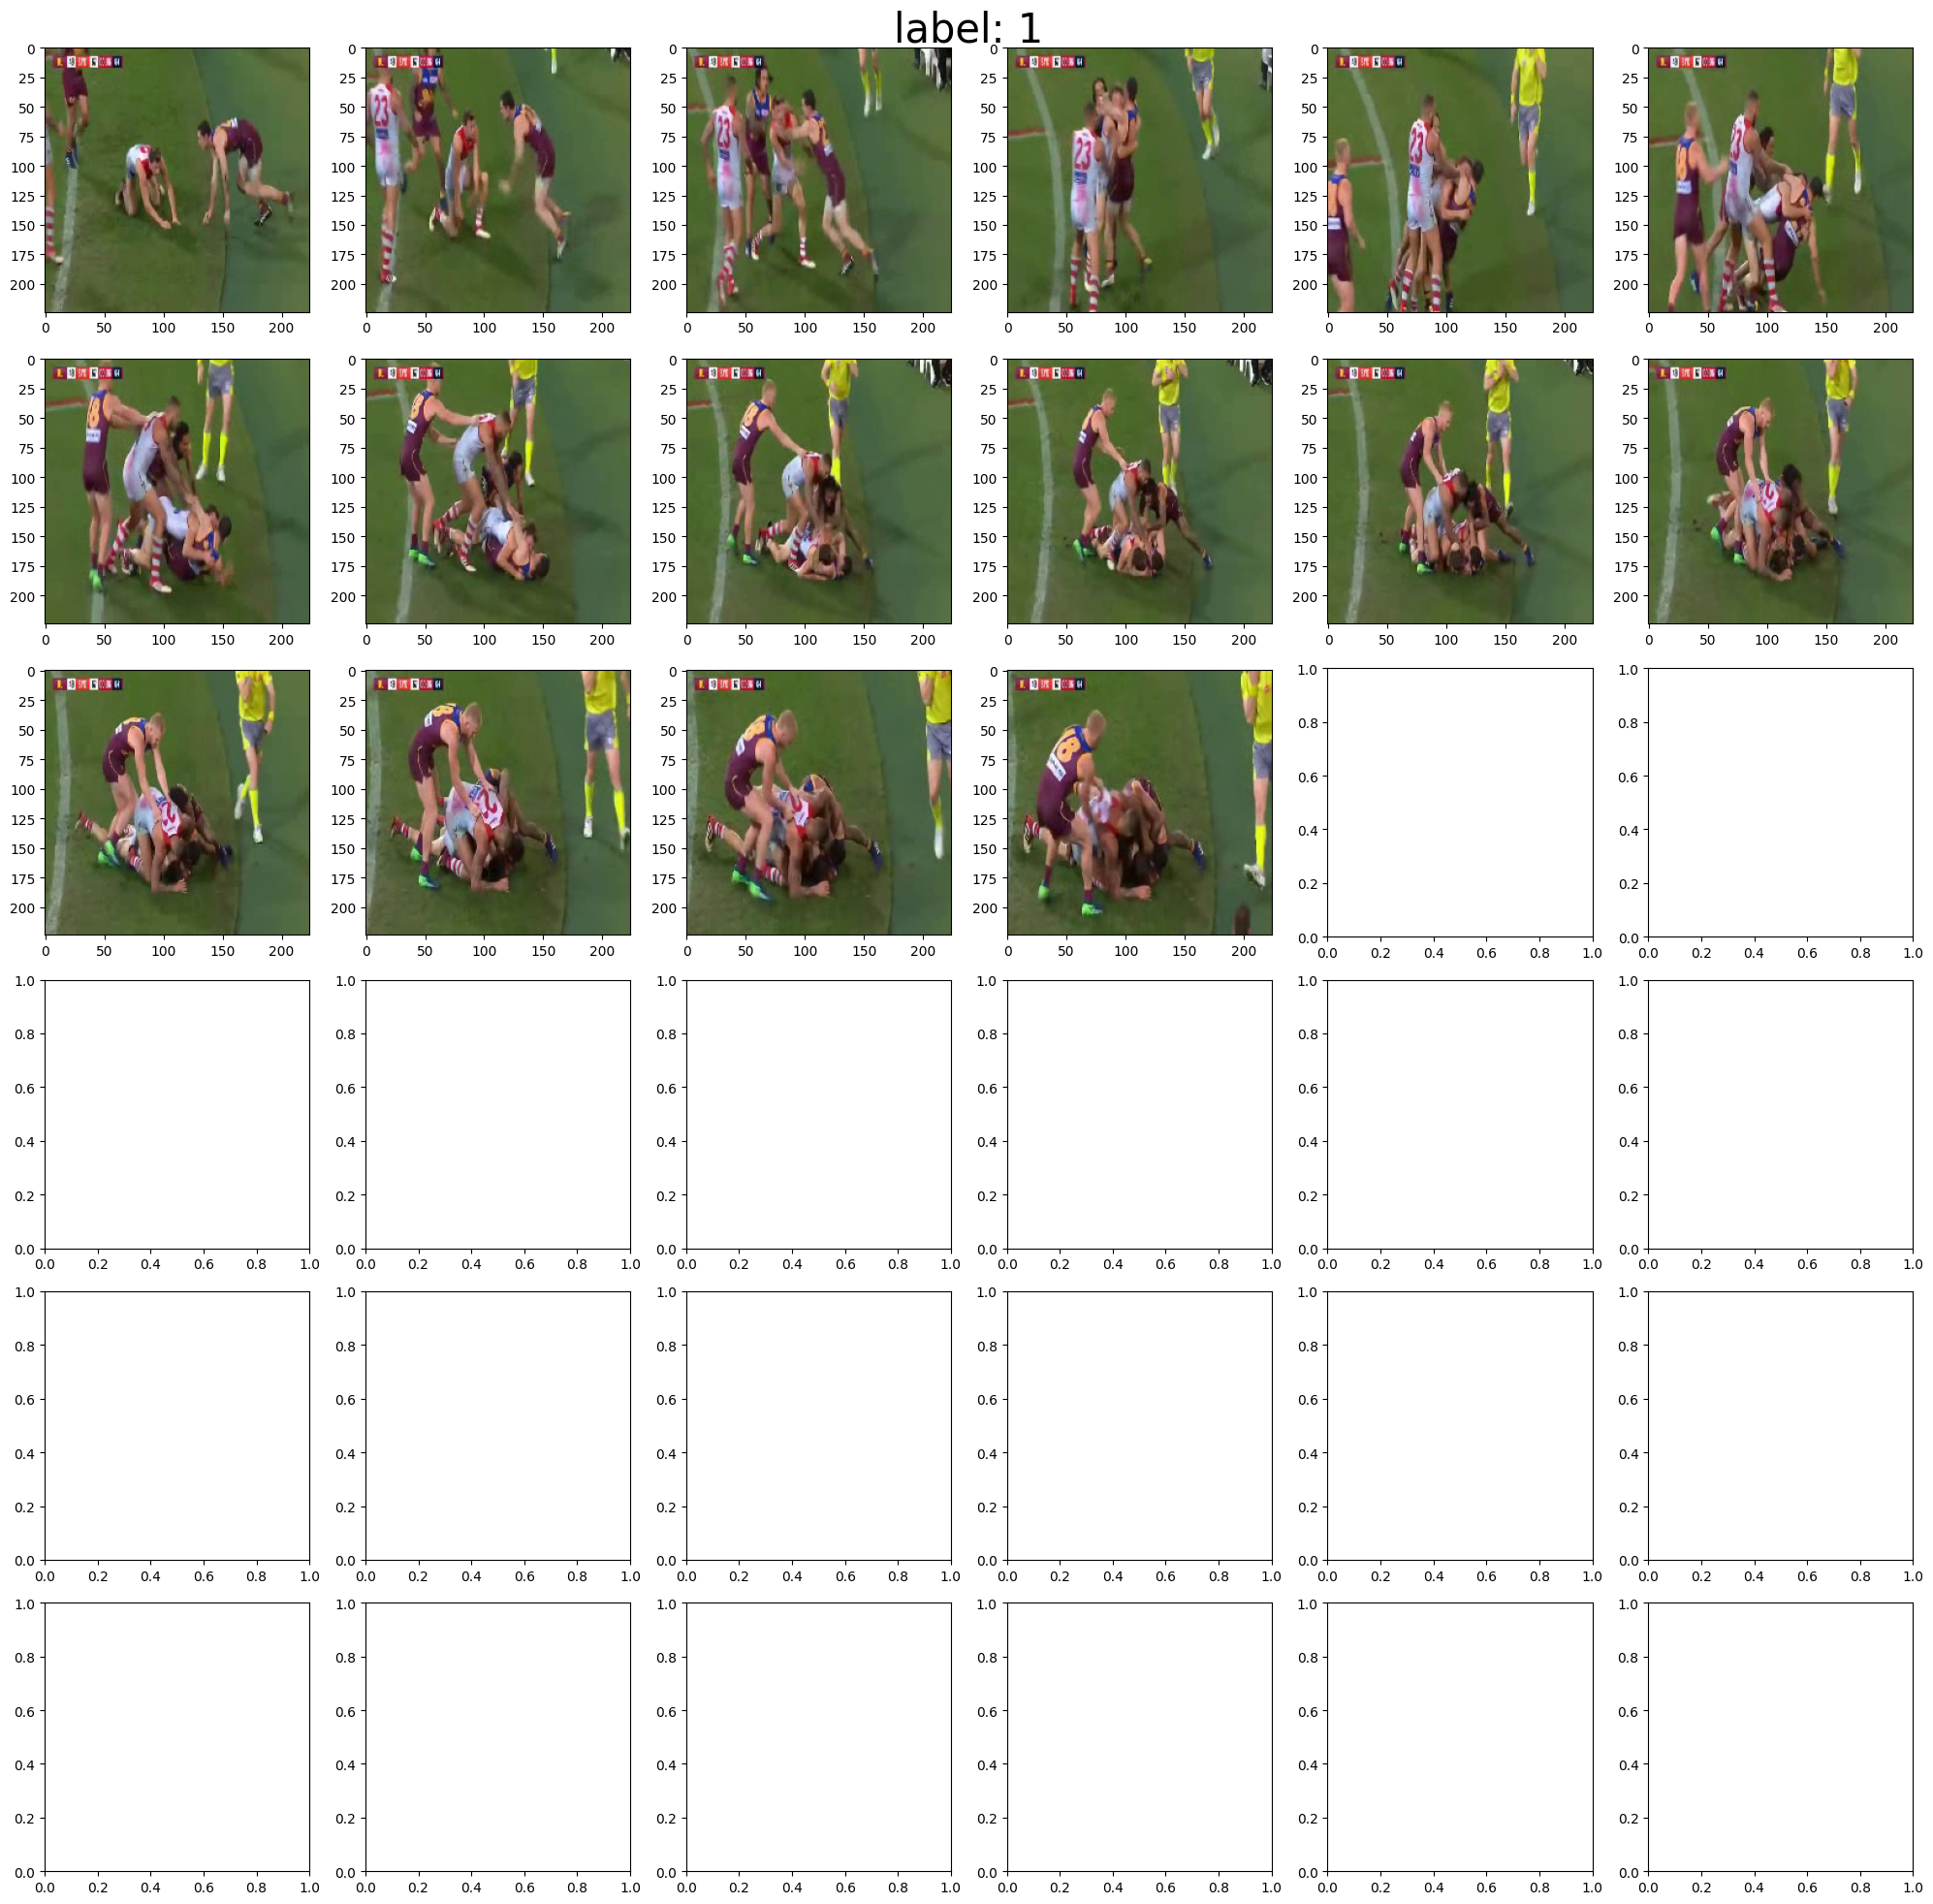

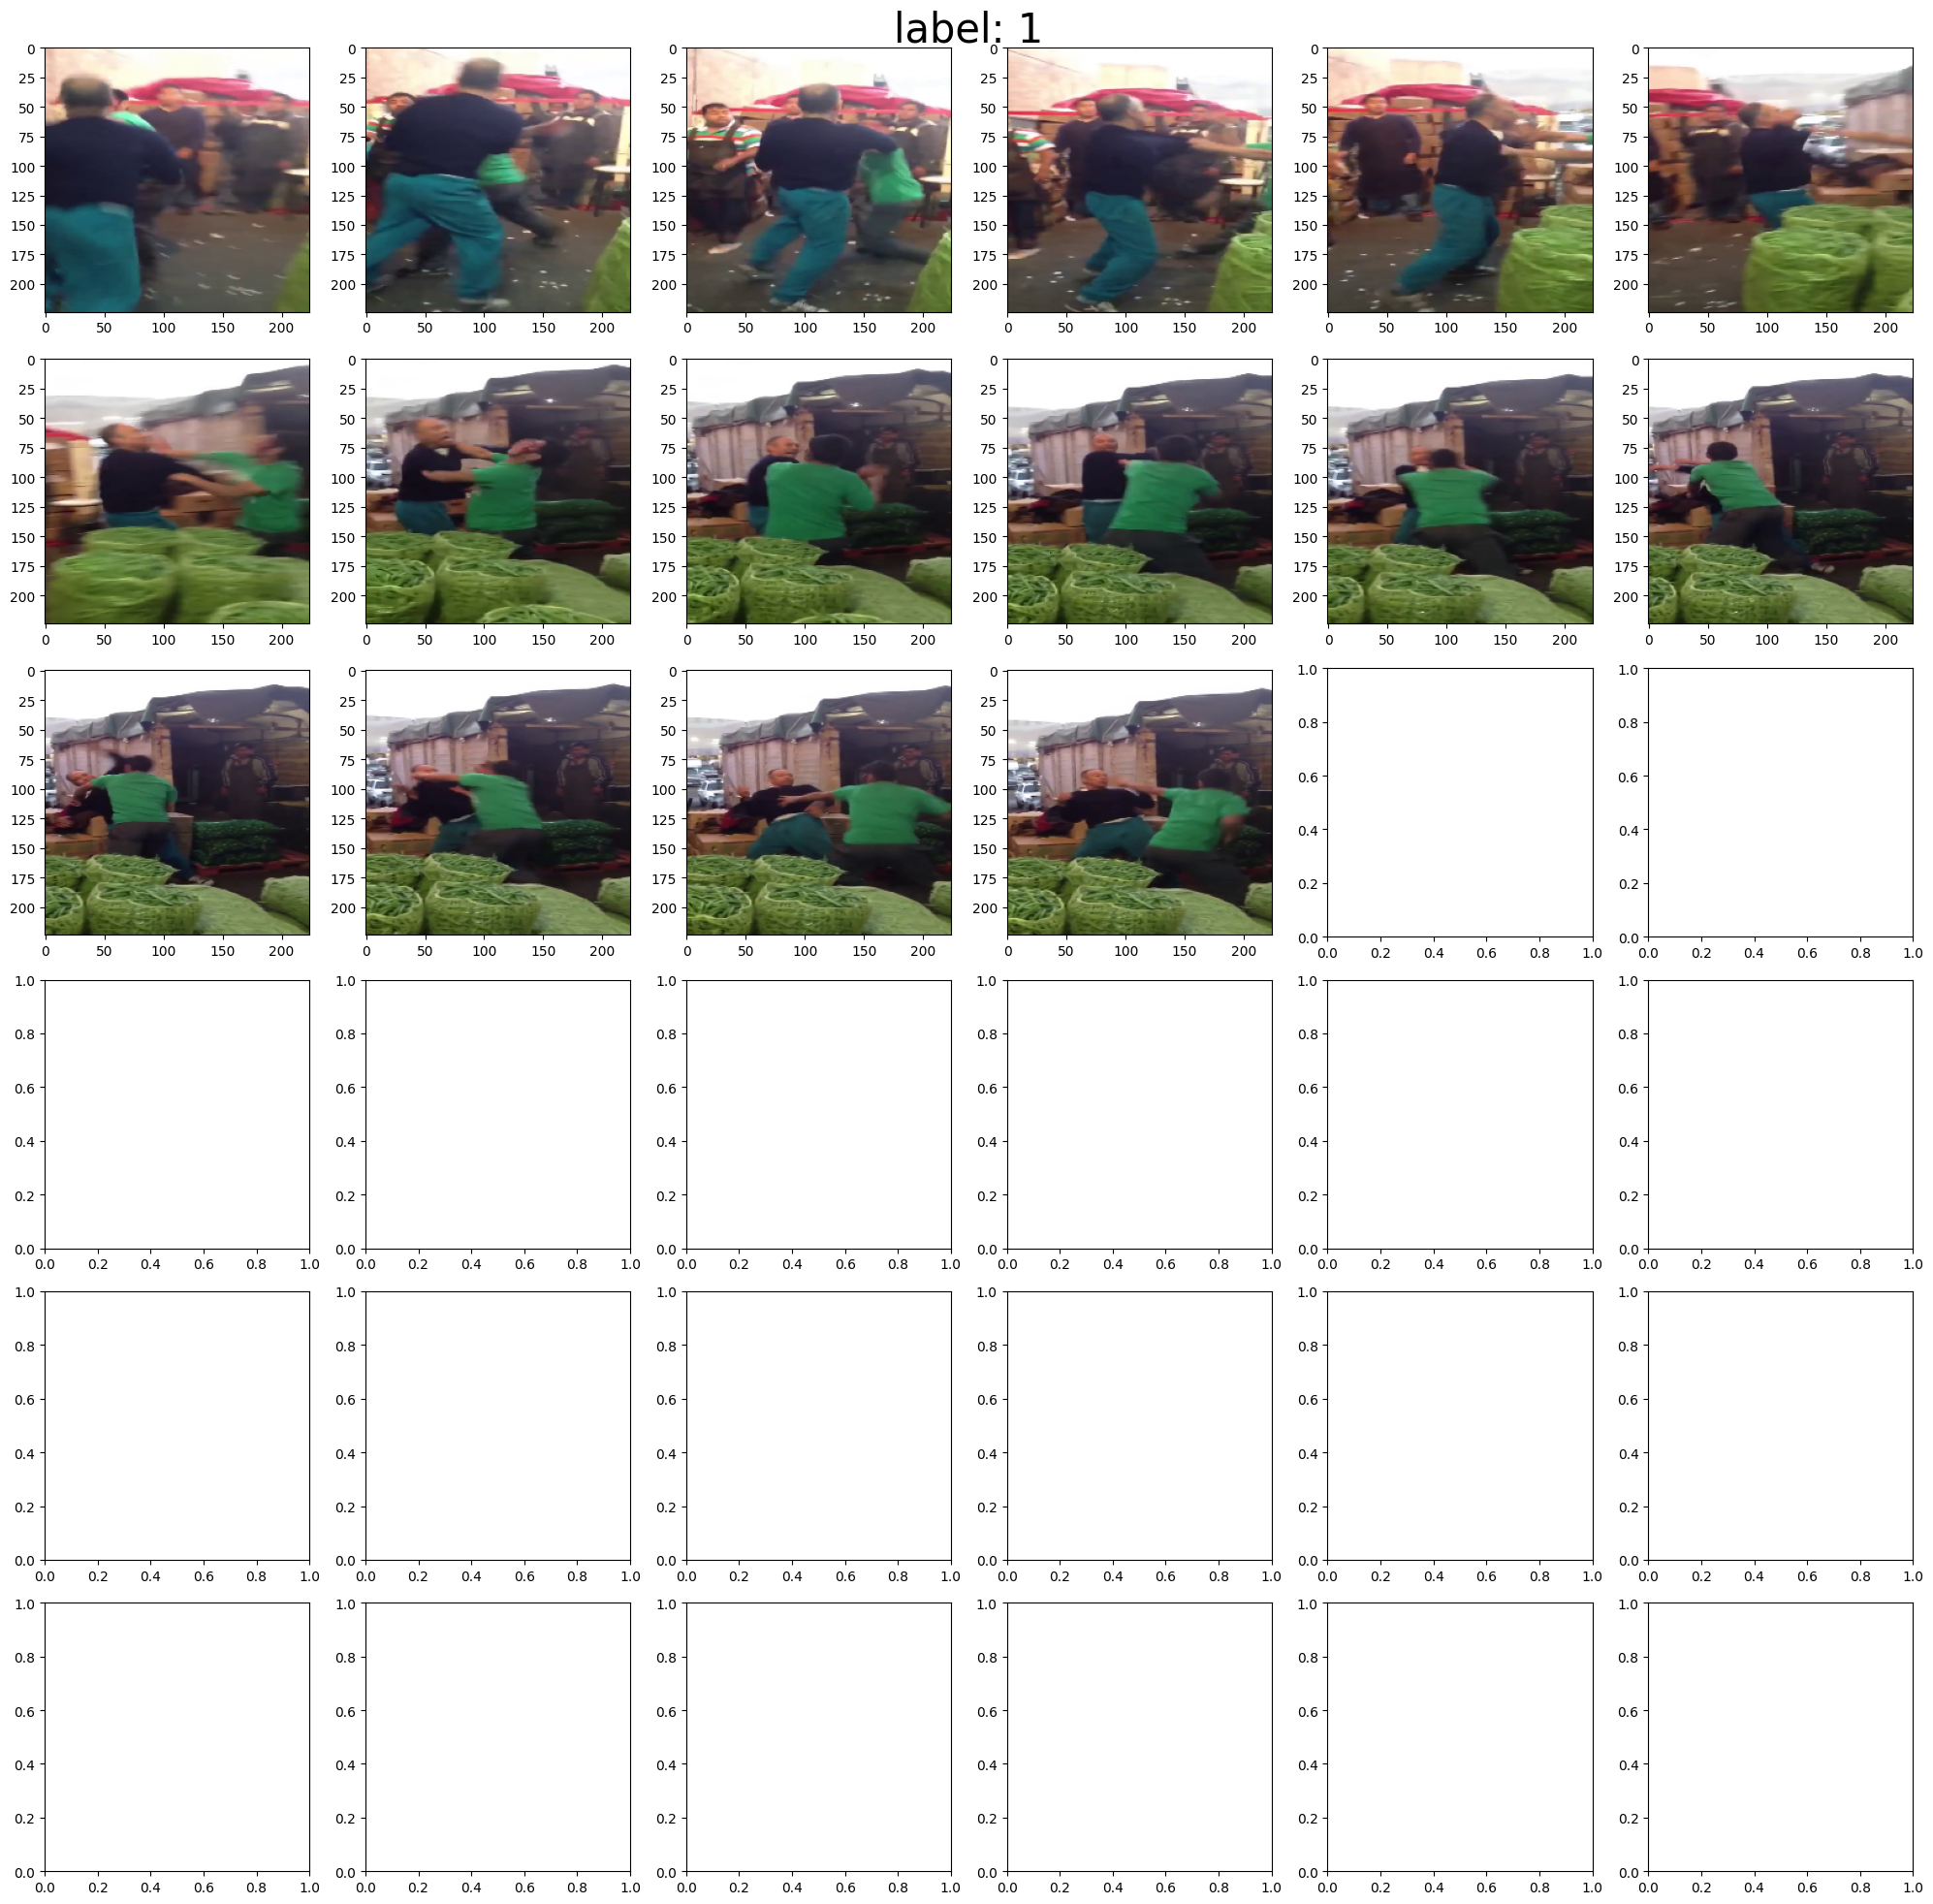

In [13]:
gen = VideoDataset(n_frames=SEQUENCE_LENGTH, df=train)
for video, label in itertools.islice(gen(),2):
        plot_video(video, label)

In [14]:
for string_, int_ in tr:
    print(string_.shape)
    break;

(8, 16, 224, 224, 3)


In [15]:
def run_experiment():
    # Initialize model
    model = create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
            embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
        ),
        positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
    )

    # Compile the model with the optimizer, loss function
    # and the metrics.
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # Train the model.
    _ = model.fit(tr, epochs=EPOCHS, validation_data=val)

    _, accuracy, top_5_accuracy = model.evaluate(ts)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return model

In [16]:
model = run_experiment()

Epoch 1/5
147/147 [==============================] - 451s 3s/step - loss: 0.7651 - accuracy: 0.5402 - top-5-accuracy: 1.0000 - val_loss: 0.6702 - val_accuracy: 0.5806 - val_top-5-accuracy: 1.0000
Epoch 2/5
147/147 [==============================] - 43s 269ms/step - loss: 0.6810 - accuracy: 0.5581 - top-5-accuracy: 1.0000 - val_loss: 0.6547 - val_accuracy: 0.5908 - val_top-5-accuracy: 1.0000
Epoch 3/5
147/147 [==============================] - 33s 216ms/step - loss: 0.6697 - accuracy: 0.5675 - top-5-accuracy: 1.0000 - val_loss: 0.6586 - val_accuracy: 0.6317 - val_top-5-accuracy: 1.0000
Epoch 4/5
147/147 [==============================] - 25s 167ms/step - loss: 0.6612 - accuracy: 0.5718 - top-5-accuracy: 1.0000 - val_loss: 0.6529 - val_accuracy: 0.6496 - val_top-5-accuracy: 1.0000
Epoch 5/5
49/49 [==============================] - 110s 2s/step - loss: 0.6468 - accuracy: 0.6513 - top-5-accuracy: 1.0000
Test accuracy: 65.13%
Test top 5 accuracy: 100.0%
